In [ ]:
!pip install facenet_pytorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.9 MB/s eta 0:00:00


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from sklearn.model_selection import train_test_split
from torch import optim, nn
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import numpy as np
import os

In [ ]:
from PIL import Image
import cv2
from tqdm.notebook import tqdm
from typing import Union, List, Dict, Callable, Tuple
import copy
import gc

In [ ]:
file_path = "/content/drive/MyDrive/NCAIR FACILITATORS UPLOAD (File responses)/Upload the compressed zipped folder of Images (File responses)/"
os.chdir(file_path)

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(35, 10))
axs = axs.ravel()

for i, filename in enumerate(os.listdir('Images')):
    dir = os.path.join('Images',filename)
    for ImagePath in os.listdir(dir):
        img = cv2.imread(os.path.join(dir, ImagePath))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img_rgb, (224, 224))
        # print(f"{filename}: The image width is {width} and the image height is {height} and {trans_image.shape}")
        axs[i].imshow(img)
        axs[i].set_title(f'Images')
        axs[i].axis('off')
        break

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [ ]:
mtcnn = MTCNN(
  image_size=224, keep_all=True, device=device)

In [ ]:
# !rm -r Images/.ipynb_checkpoints

In [ ]:
import pandas as pd

def load_images(root_dir):
    data = []
    for i, filename in enumerate(os.listdir(root_dir)):
        dir = os.path.join('Images',filename)
        for ImagePath in os.listdir(dir):
            image_path = os.path.join(dir, ImagePath)
            data.append([image_path, filename])


    df = pd.DataFrame(data, columns=['Filepath', 'Class'])
    return df

data = load_images("Images")
class_map = {c:i for i, c in enumerate(data['Class'].unique())}
data['Class'] = data['Class'].map(class_map)
file_paths = data['Filepath'].values
classes = data['Class'].values

# Perform a stratified split
train_paths, val_paths, train_classes, val_classes = train_test_split(file_paths, classes, test_size=0.1, stratify=classes)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import albumentations as A
from albumentations.pytorch import ToTensorV2

data_transform = A.Compose([
    A.Resize(height=224, width=224),
    ToTensorV2()
])

In [ ]:
ohe = OneHotEncoder(sparse_output=False)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, paths, classes, transform = None):
        self.paths = paths
        self.labels = ohe.fit_transform(classes.reshape(-1,1))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        imagepath = self.paths[idx]
        img = cv2.imread(imagepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.resize(img_rgb, (224, 224))
        image = self.transform(image=img)
        return image['image'], self.labels[idx]


In [ ]:
train_data = CustomDataset(train_paths, train_classes, data_transform)
val_data = CustomDataset(val_paths, val_classes, data_transform)

train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(val_data, batch_size=32)

In [ ]:
mtcnn = MTCNN(
  image_size=224, keep_all=True, device=device)

In [ ]:
# aligned = []
# names = []
# for x, y in val_loader:
#     boxes, _ = mtcnn.detect(x.permute(0, 3, 2, 1))
#     if boxes is not None:
#         x_aligned = mtcnn(x.permute(0, 3, 2, 1))
#         # Create a mask of non-None values
#         mask = [i is not None for i in x_aligned]
#         # Filter x_aligned and y using the mask
#         x_aligned = [i for (i, m) in zip(x_aligned, mask) if m]
#         y_aligned = [i for (i, m) in zip(y, mask) if m]
#         if x_aligned:
#             aligned.append(x_aligned)
#             names.append(y_aligned)


In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(class_map)
).to(device)



  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
def get_accuracy(labels, outputs) -> float:
    _, preds = torch.max(outputs, 1)
    _, true = torch.max(labels, 1)
    correct = (preds == true).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

In [ ]:
def train_model(model: nn.Module, criterion: Callable, optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler, train_dl: DataLoader, val_dl: DataLoader,
                num_epochs: int = 10) -> Tuple[nn.Module, List[float], List[float]]:

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 2.0
    patience = 5
    counter = 0
    train_loss = []
    valid_loss = []

    for epoch in range(num_epochs):

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training Phase
        model.train()
        ns_T = 0
        running_acc_T = 0
        running_loss_T = 0.0

        with tqdm(train_dl, desc=f"Training Epoch {epoch+1}") as pbar:

            for images, labels in pbar:
                labels = labels.float()

                aligned = []
                classes = []
                boxes, _ = mtcnn.detect(images.permute(0, 3, 2, 1))
                if boxes is not None:
                    x_aligned = mtcnn(images.permute(0, 3, 2, 1))
                    # Create a mask of non-None values
                    mask = [i is not None for i in x_aligned]
                    # Filter x_aligned and y using the mask
                    images_aligned = [i[:1,:,:,:] for (i, m) in zip(x_aligned, mask) if m]
                    labels_aligned = [i for (i, m) in zip(labels, mask) if m]

                    if x_aligned:
                        aligned.append(images_aligned)
                        classes.append(labels_aligned)

                if aligned and classes:
                    images, labels = torch.vstack(aligned[0]).to(device), torch.vstack(classes[0]).to(device)
                else:
                    continue
                if images.shape[0] <= 1:
                    continue
                outputs = model(images)
                ns_T += outputs.shape[0]
                acc_value = get_accuracy(labels, outputs)
                optimizer.zero_grad()

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss_T += loss.item() * images.size(0)
                running_acc_T += acc_value

        # Validation Phase
        model.eval()

        ns_V = 0
        running_acc_V = 0
        running_loss_V = 0.0

        with tqdm(val_dl, desc=f"Validation Epoch {epoch+1}") as pbar:

            with torch.no_grad():
                for images, labels in pbar:
                    labels = labels.float()

                    aligned = []
                    classes = []
                    boxes, _ = mtcnn.detect(images.permute(0, 3, 2, 1))
                    if boxes is not None:
                        x_aligned = mtcnn(images.permute(0, 3, 2, 1))
                        # Create a mask of non-None values
                        mask = [i is not None for i in x_aligned]
                        # Filter x_aligned and y using the mask
                        images_aligned = [i[:1,:,:,:] for (i, m) in zip(x_aligned, mask) if m]
                        labels_aligned = [i for (i, m) in zip(labels, mask) if m]
                        if x_aligned:
                            aligned.append(images_aligned)
                            classes.append(labels_aligned)

                    images, labels = torch.vstack(aligned[0]).to(device), torch.vstack(classes[0]).to(device)

                    outputs = model(images)
                    ns_V += outputs.shape[0]
                    acc_value = get_accuracy(labels, outputs)
                    optimizer.zero_grad()

                    loss = criterion(outputs, labels)

                    running_loss_V += loss.item() * images.size(0)
                    running_acc_V += acc_value

        Train_loss = running_loss_T / ns_T
        train_loss.append(Train_loss)
        Valid_loss = running_loss_V / ns_V
        valid_loss.append(Valid_loss)
        Train_acc = running_acc_T / len(train_dl)
        Valid_acc = running_acc_V / len(val_dl)

        scheduler.step(Valid_loss)
        print(f'Train Loss: {(Train_loss):.4f} Train Acc: {Train_acc:.4f} Valid Loss: {(Valid_loss):.4f} Valid Acc: {Valid_acc:.4f}')

        if Valid_acc > best_acc:
            print(f'Val Accuracy increased from {best_acc:.4f} to {Valid_acc:.4f}')
            best_acc = Valid_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        if Valid_loss < best_loss:
            print(f'Val Loss decreased from {(best_loss):.4f} to {(Valid_loss):.4f}')

            best_loss = Valid_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break


    print('Best accuracy {:.4f} Best loss {:.4f}'.format(best_acc, best_loss))
    model.load_state_dict(best_model_wts)

    torch.cuda.empty_cache()
    gc.collect()

    return model, train_loss, valid_loss





In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(),lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,patience=3)

TRmodel, tl, vl = train_model(resnet, criterion, optimizer, scheduler, train_dl, val_dl, num_epochs=8)

Epoch 0/7
----------


Training Epoch 1:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 1.7584 Train Acc: 0.5503 Valid Loss: 1.3370 Valid Acc: 0.5714
Val Accuracy increased from 0.0000 to 0.5714
Val Loss decreased from 2.0000 to 1.3370
Epoch 1/7
----------


Training Epoch 2:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.6951 Train Acc: 0.9275 Valid Loss: 0.9450 Valid Acc: 0.7143
Val Accuracy increased from 0.5714 to 0.7143
Val Loss decreased from 1.3370 to 0.9450
Epoch 2/7
----------


Training Epoch 3:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3557 Train Acc: 0.9778 Valid Loss: 0.8160 Valid Acc: 0.7143
Val Loss decreased from 0.9450 to 0.8160
Epoch 3/7
----------


Training Epoch 4:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3121 Train Acc: 0.9500 Valid Loss: 0.8101 Valid Acc: 0.7143
Val Loss decreased from 0.8160 to 0.8101
Epoch 4/7
----------


Training Epoch 5:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.6291 Train Acc: 0.8770 Valid Loss: 0.8939 Valid Acc: 0.7143
Epoch 5/7
----------


Training Epoch 6:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1906 Train Acc: 0.9444 Valid Loss: 1.0352 Valid Acc: 0.7143
Epoch 6/7
----------


Training Epoch 7:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1754 Train Acc: 0.8607 Valid Loss: 1.2273 Valid Acc: 0.7143
Epoch 7/7
----------


Training Epoch 8:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1964 Train Acc: 0.9778 Valid Loss: 1.0218 Valid Acc: 0.7143
Best accuracy 0.7143 Best loss 0.8101


In [ ]:
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def inference(model, imagepath):
    img = cv2.imread(imagepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(img, (224, 224))
    boxes, _ = mtcnn.detect(image)
    if boxes is not None:
        aligned = mtcnn(image)
        outputs = model(aligned.to(device))
        _, preds = torch.max(outputs, 1)
        pred_class = get_key(preds.item(), class_map)

        # Create figure and axes
        fig, ax = plt.subplots()

        # Display the image
        ax.imshow(image)

        # Create a Rectangle patch for each bounding box
        rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], boxes[0][3]-boxes[0][1], linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add text for the predicted class and probability
        plt.text(0, 0, f'Predicted class: {pred_class}, Probability: {torch.max(outputs).item()}', color='white', backgroundcolor='black')

        plt.show()


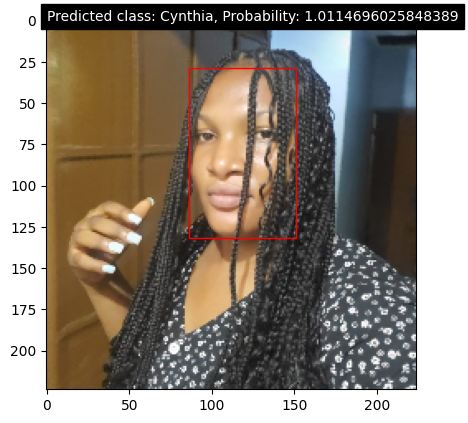

In [ ]:
inference(TRmodel, "Images/Cynthia/Cynthia_Image_10.jpeg")

In [ ]:
class_map

{'Komolafe': 0,
 'Mac': 1,
 'Adedayo': 2,
 'Yisau': 3,
 'Cynthia': 4,
 'Joseph': 5,
 'Michael': 6,
 'Jason': 7,
 'Ogechi': 8,
 'Emmanuel': 9,
 'Mubaraq': 10,
 'Nasir': 11}